<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Neural-Machine-Translation-Seq2Seq" data-toc-modified-id="Neural-Machine-Translation-Seq2Seq-1">Neural Machine Translation Seq2Seq</a></span><ul class="toc-item"><li><span><a href="#Download-dataset" data-toc-modified-id="Download-dataset-1.1">Download dataset</a></span></li><li><span><a href="#Preparing-data" data-toc-modified-id="Preparing-data-1.2">Preparing data</a></span></li><li><span><a href="#Encoder" data-toc-modified-id="Encoder-1.3">Encoder</a></span></li><li><span><a href="#Decoder" data-toc-modified-id="Decoder-1.4">Decoder</a></span></li><li><span><a href="#Seq2Seq" data-toc-modified-id="Seq2Seq-1.5">Seq2Seq</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-1.6">Training</a></span></li><li><span><a href="#Generate-Text" data-toc-modified-id="Generate-Text-1.7">Generate Text</a></span></li><li><span><a href="#BLEU-metrics" data-toc-modified-id="BLEU-metrics-1.8">BLEU metrics</a></span></li><li><span><a href="#Writer-to-tensorboard-logs" data-toc-modified-id="Writer-to-tensorboard-logs-1.9">Writer to tensorboard logs</a></span></li></ul></li></ul></div>

# Neural Machine Translation Seq2Seq

In [27]:
! mkdir runs

mkdir: runs: File exists


## Download dataset

In [2]:
! wget https://github.com/yandexdataschool/nlp_course/raw/2020/week04_seq2seq/data.txt -O data.txt

--2021-07-31 17:34:25--  https://github.com/yandexdataschool/nlp_course/raw/2020/week04_seq2seq/data.txt
Распознаётся github.com (github.com)… 140.82.121.4
Подключение к github.com (github.com)|140.82.121.4|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week04_seq2seq/data.txt [переход]
--2021-07-31 17:34:25--  https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week04_seq2seq/data.txt
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 12905335 (12M) [text/plain]
Сохранение в: «data.txt»

data.txt            100%[===================>]  12,31M  7,00MB/s    за 1,8s    

2021-07-31 17:34:28 (7,00 MB/s) - «data.txt» сохранён [1290

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import torchvision

import torchtext
from torchtext.legacy.data import Field, BucketIterator

import spacy

import random
import math
import time
import numpy as np

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer

We'll set the random seeds for deterministic results

In [5]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Preparing data
Here comes the preprocessing

In [6]:
tokenizer_W = WordPunctTokenizer()

def tokenize_ru(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())[::-1]

def tokenize_en(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [7]:
SRC = Field(tokenize=tokenize_ru,
           init_token="<sos>",
           eos_token="<eos>",
           lower=True)

TRG = Field(tokenize=tokenize_en,
           init_token="<sos>",
           eos_token="<eos>",
           lower=True)

dataset = torchtext.legacy.data.TabularDataset(
    path="data.txt",
    format="tsv",
    fields=[("trg", TRG), ("src", SRC)]
)

In [16]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 39992
Number of validation examples: 2500
Number of testing examples: 7498


Setup vocabulary

In [17]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [18]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 14157
Unique tokens in target (en) vocabulary: 10158


And here is example from train dataset

In [22]:
print(vars(train_data.examples[1]))

{'trg': ['each', 'bathroom', 'is', 'fitted', 'with', 'a', 'hairdryer', 'and', 'free', 'toiletries', '.'], 'src': ['.', 'принадлежностями', 'косметическими', '-', 'туалетно', 'бесплатными', 'и', 'феном', 'с', 'комната', 'ванная', 'удобств', 'числе', 'в']}


Setup torch device

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort_key=_len_sort_key
)

## Encoder

In [120]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout, bidirectional):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, dropout=dropout, bidirectional=bidirectional)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, src):
        # src = [src sent len, batch size]
        
        # Compute an embedding from the src data and apply dropout to it
        embedded = self.dropout(self.embedding(src))
        
        # embedded = [src sent len, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN
        # outputs, hidden and cell shoud be initialized here. Refer to nn.LSTM docs :)
        
        _, (hidden, cell) = self.rnn(embedded)
        
        # outputs = [src sent len, batch size, hid dim * n_directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]
        
        # outputs are always from the top hidden layer
        if self.bidirectional:
            hidden = hidden.reshape(self.n_layers, 2, -1, self.hid_dim)
            hidden = hidden.transpose(1, 2).reshape(self.n_layers, -1, 2 * self.hid_dim)
            
            cell = cell.reshape(self.n_layers, 2, -1, self.hid_dim)
            cell = cell.transpose(1, 2).reshape(self.n_layers, -1, 2 * self.hid_dim)
        
        return hidden, cell         

## Decoder

In [121]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, dropout=dropout)
        
        self.out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n leayers, batch size, hid dim]
        #context = [n layers, batch, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        #Compute an embedding from the input data and apply dropout to it
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN.
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs :)
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #sent len and n directions will always be 1 in the decoder, therefore
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

## Seq2Seq

In [122]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        if encoder.bidirectional:
            assert encoder.hid_dim * 2 == decoder.hid_dim, \
                "Hidden dimensions of encoder and decoder must be equal!"
        else:
            assert encoder.hid_dim == decoder.hid_dim, \
                    "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            #get the highest predicted token from our predictions
            top1 = output.argmax(1)
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs

## Training

In [124]:
# For reloading. Use Attention in Seq2Seq as homework
# import modules
# import imp
# imp.reload(modules)

# Encoder = modules.Encoder
# Attention = modules.Attention
# Decoder = modules.DecoderWithAttention
# Seq2Seq = modules.Seq2Seq

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
BIDIRECTIONAL = True

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM // 2, N_LAYERS, ENC_DROPOUT, BIDIRECTIONAL)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

#Dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [125]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(14157, 256)
    (rnn): LSTM(256, 256, num_layers=2, dropout=0.5, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10158, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=10158, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [126]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 17,743,534 trainable parameters


In [127]:
PAD_IDX = TRG.vocab.stoi["<pad>"]
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, OUTPUT_DIM)
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10 == 0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
            
            clear_output(True)
            ax[0].plot(history, label="train loss")
            ax[0].set_xlabel("Batch")
            ax[0].set_title("Train loss")
            if train_history is not None:
                ax[1].plot(train_history, label="general train history")
                ax[1].set_xlabel("Epoch")
            if valid_history is not None:
                ax[1].plot(valid_history, label="general valid history")
            plt.legend()
            
            plt.show()
            
    return epoch_loss / len(iterator)


def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            
            src = batch.src
            trg = batch.trg
            
            output = model(src, trg, 0)
            
            output = output[1:].view(-1, OUTPUT_DIM)
            trg = trg[1:].view(-1)
            
            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
            
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins*60))
    return elapsed_mins, elapsed_secs

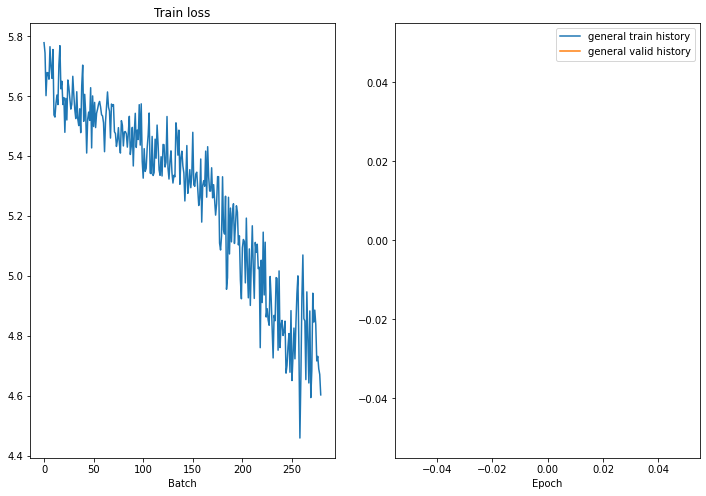

KeyboardInterrupt: 

In [131]:
train_history = []
valid_history = []

N_EPOCHS = 12
CLIP = 5

best_valid_loss = float("inf")

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss;
        torch.save(model.state_dict(), "best-val-model.pt")
        
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:.3f} | Train PPL: {math.exp(valid_loss):7.3f}")

## Generate Text

In [129]:
def cut_on_eos(tokens_iter):
    for token in tkens_iter:
        if token == "<eos>":
            break
        yield token
        
def remove_tech_tokens(tokens_iter, tokens_to_remove=["<eos>", "<sos>", "<unk>", "<pad>"]):
    return [x for x in tokens_iter if x not in tokens_to_remove]

def generate_translation(src, trg, model, TRG_vocab):
    model.eval()
    
    output = model(src, trg, 0)
    output = output[1:].argmax(-1)
    
    original = remove_tech_tokens(cut_on_eos([TRG_vocab.itos[x] for x in list(trg[:,0].cpu().numpy())]))
    generated = remove_tech_tokens(cut_on_eos([TRG_vocab.itos[x] for x in list(output[:, 0]).cpu().numpy()]))
    
    print("Original: {}".format(" ".join(original)))
    print("Generated: {}".format(" ".join(generated)))
    print()
    
def get_text(x, TRG_vocab):
    generated = remove_tech_tokens(cut_on_eos([TRG_vocab.itos[elem] for elem in list(x)]))
    return generated

In [130]:
model.load_state_dict(torch.load("best-val-model.pt"))
batch = next(iter(test_iterator))

for idx in range(10):
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

FileNotFoundError: [Errno 2] No such file or directory: 'best-val-model.pt'

## BLEU metrics

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
import tqdm
original_text = []
generated_text = []
model.eval()
with torch.no_grad():
    
    for i, batch in tqdm.tqdm(enumerate(test_iterator)):
        
        src = batch.src
        trg = batch.trg
        
        output = model(src, trg, 0) #turn off teacher forcing
        
        output = output[1:].argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg[1:].cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])

In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

## Writer to tensorboard logs

In [40]:
# default `log_dir` is "runs" - we'll be more specific here
# writer = SummaryWriter('runs/seq2seq_without_attention')

In [118]:
# # Writing To TensorBoard
# # get some random training images
dataiter = iter(test_iterator)
i, batch = next(dataiter)
print(i[0].shape, i[1].shape)

# # # create grid of images
# img_grid = torchvision.utils.make_grid(i[0])

# # # write to tensorboard
# writer.add_image('seq2seq', img_grid)
    
writer.add_graph(model, (i[0], i[1]))
writer.close()

torch.Size([17, 128]) torch.Size([7, 128])


IndexError: index out of range in self